# Normalizing Radar Cross Sections

The premise of microwave remote sensing is the amplitude or energy of an EM wave, given by $E_0$, and the related concept of energy per unit of time, given by $P$ (with unit Watts). Radar imaging measures power over distributed areas where we want to know how much scattered energy is returned to the radar system.  This can be expressed as a ratio between scattered power ($P_s$) and incident power ($P_i$), so that:

$$\sigma = \frac{P_s}{Pi} 4 \pi R^2 \, [m^2] \quad \text{,}  $$

provides a backscatter coefficient for distributed targets per given reference area, also known as a radar scattering cross section. 

For backscattering from a  ground surface an increasingly larger target areas of measurement will increase the total backscatter power by the same factor and so the radar cross sections changes. To accommodate for this undesirable aspect, which does not represent a faithful description of the target ground area, radar cross sections are normalized by an approximation of the geometrical area (i.e. illuminated ground area) measured, as follows:

$$\sigma^0 = \sigma /  \hat{A} \, [1] \quad \text{.} $$

Backscattering can be highly dependent on the angle of the incident energy when the targetted area is signified by reflective objects of different heights (such as trees). This phenomenon is called volume scattering and can be accounted for by again normalizing for by the cosine of the local incidence angle:

$$\gamma^0 = \sigma^0 / \cos{\theta_i} \, [1] $$

Now let's have a look at some backscatter coefficients ($\gamma^0$ = gmr, $\sigma^0$ = sig0) and the local incidence angle (plia) over the same area around the city of Modena, Italy.

## Loading Normalized Backscatter Data

We first load the data with `xarray`, select an area of interest (AOI), and modify the variables `gmr` and `sig0` by dividing by 100. The latter step is necessary as the variables have been multiplied by 100 to decrease the file size.

In [1]:
import xarray as xr
import rioxarray
from pathlib import Path
import folium

In [47]:
def _preprocess(x):
    return x.rename({"band_data": Path(x.encoding["source"]).parent.stem}).squeeze("band").drop_vars("band")

ds = xr.open_mfdataset("../data/A0105/EQUI7_EU010M/E047N012T1/**/*.tif", engine="rasterio", combine='nested', preprocess=_preprocess)
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 10000, y: 10000)
Coordinates:
  * x            (x) float64 80kB 4.7e+06 4.7e+06 4.7e+06 ... 4.8e+06 4.8e+06
  * y            (y) float64 80kB 1.3e+06 1.3e+06 1.3e+06 ... 1.2e+06 1.2e+06
    spatial_ref  int64 8B 0
Data variables:
    gmr          (y, x) float32 400MB dask.array<chunksize=(1, 10000), meta=np.ndarray>
    plia         (y, x) float32 400MB dask.array<chunksize=(1, 10000), meta=np.ndarray>
    sig0         (y, x) float32 400MB dask.array<chunksize=(1, 10000), meta=np.ndarray>

In [50]:
ds_aoi = ds.sel(x=slice(4.78e6, 4.795e6), y=slice(1.28e6, 1.265e6)).compute()
ds_aoi["sig0"] = ds_aoi["sig0"] / 100
ds_aoi["gmr"] = ds_aoi["gmr"] / 100

['gmr', 'plia', 'sig0']

## Area of Interest

Let's have a closer look at the area of interest by taking the bounding box of the `xarray` Dataset with `rioxarray` method `transform_bounds` and using this to define the view of a leaflet map with `folium`.

In [27]:
bbox = ds_aoi.rio.transform_bounds("EPSG:4326")

folium.Map(
    max_bounds=True,
    location=[bbox[1] + (bbox[3] - bbox[1]) / 2, bbox[0] + (bbox[2] - bbox[0]) / 2],
    min_lat=bbox[1],
    max_lat=bbox[3],
    min_lon=bbox[0],
    max_lon=bbox[2],
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)

## Visualizing the Backscatter Coefficients

Now we can visualize the backscatter coefficients by using the `xarray` method `plot`, and by plotting these on a `matplotlib` figure with 3  `axes` (i.e. 1 subplot).

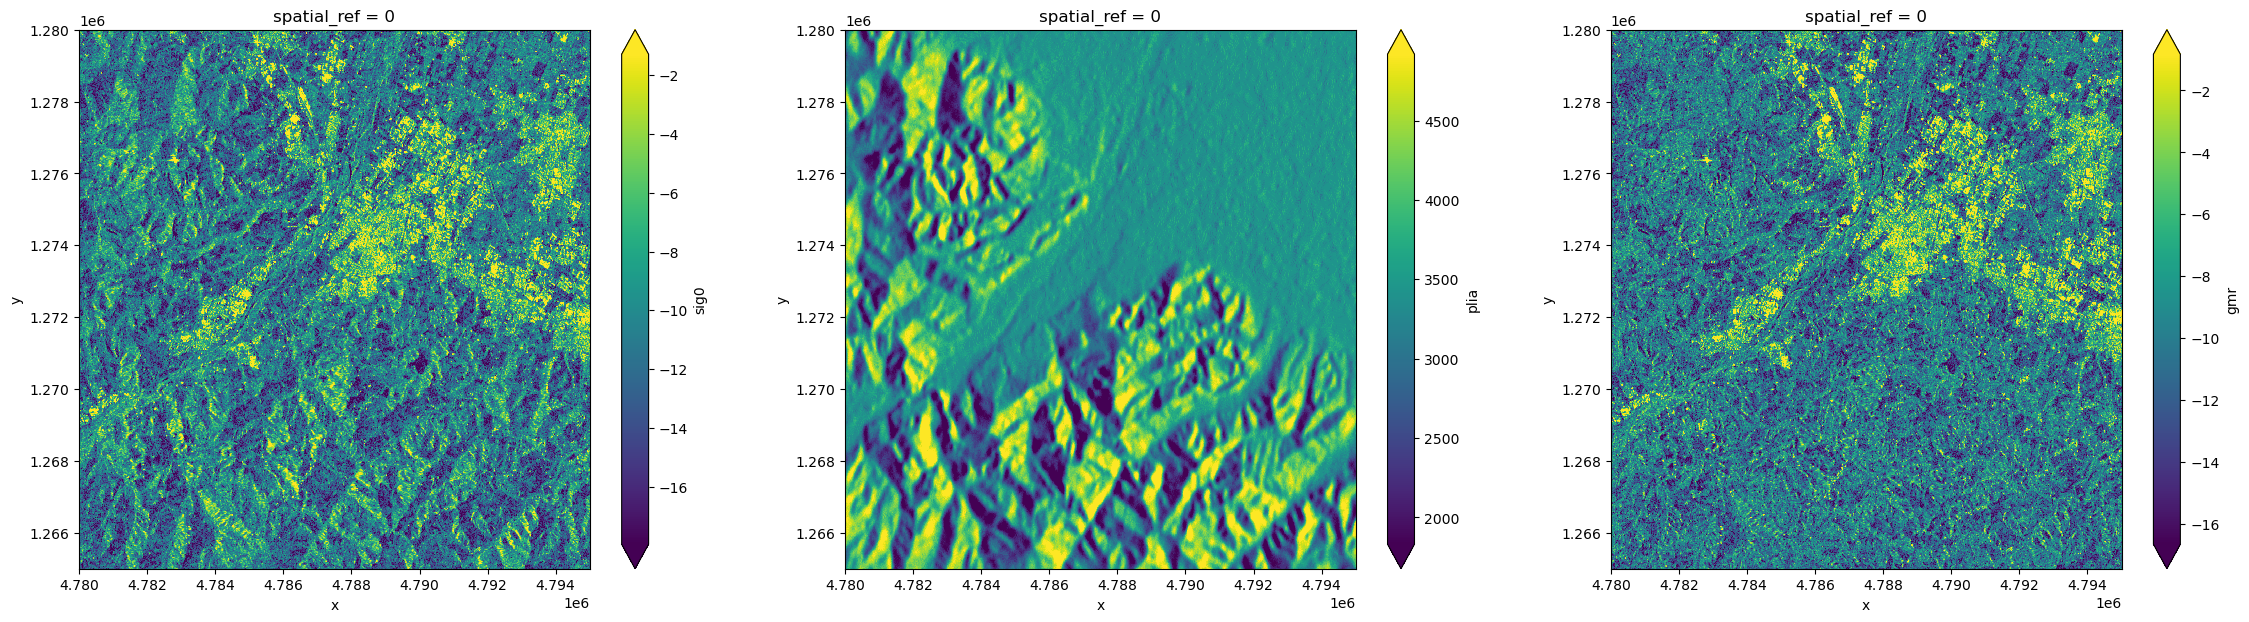

In [71]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1,3, figsize=(28,7), dpi=100)

for i, var in enumerate([i for i in ds_aoi.data_vars][::-1]):
    ds_aoi[var].plot(ax=axis[i], robust=True)

The main difference in backscatter coefficients in the above example relates to the approximation of the geometrical area used in the normalization.
The approximation of illuminated ground area for $\sigma^0$ is calculate by a tangent on an ellipsoid model for the Earth. The $\gamma^0$ backscatter coefficient was generated with a terrain flattening method; integrating through a reference digital elevation model to determine the local illuminated area at each radar position. It is clear by looking at the local incidence angles that the area is marked by topographically severe terrain which biases simplified approximation of the illuminated ground area for normalization, such as the ellipsoid-based approach.